In [1]:
# Import packages
# import pandas as pd
# import numpy as np
# from sklearn import linear_model
# import requests
# from nba_api.stats import endpoints
# from matplotlib import pyplot as plt


In [2]:

# Access the leagueleaders module through endpoints & assign the class to "data"
# data = endpoints.leagueleaders.LeagueLeaders() 
# df = data.league_leaders.get_data_frame()
# df.describe


In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import requests
# from nba_api.stats import endpoints
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

In [2]:
import scipy
import emcee
import seaborn as sns
sns.set()
current_palette = sns.color_palette()

/Users/amitklinger/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Inputs:
year = 2014
stats = 'advanced' # 'basic' / 'advanced' (with PER)
MIN_GAMES = 20 # players with less games will be filtered out

In [4]:
if stats is 'basic':
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
elif stats is 'advanced':
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(year) # advanced statistics - with PER
else:
    print("Unknown stats mode: Please choose 'basic' / 'advanced'")
print('fetching url:\n{}'.format(url))

fetching url:
https://www.basketball-reference.com/leagues/NBA_2014_advanced.html


In [5]:
def fetch_data(url):
    r = requests.get(url)
    r_html = r.text
    soup = BeautifulSoup(r_html,'html.parser')

    table = soup.find_all(class_="full_table")

    # Extracting List of column names
    head = soup.find(class_="thead")
    column_names_raw = [head.text for item in head][0]
    column_names_polished = column_names_raw.replace("\n",",").split(",")[2:-1]
#     column_names_polished = list(filter(lambda f: f != '\xa0', column_names_polished)) # remove empty columns
    #     print(column_names_polished)
    #     print(len(column_names_polished))

    # Extracting full list of player_data
    players=[]
    for i in range(len(table)):
        player_=[]
        for td in table[i].find_all("td"):
            player_.append(td.text)
        players.append(player_)
#     df = pd.DataFrame(players, columns=column_names_polished).set_index("Player")
    df = pd.DataFrame(players, columns=column_names_polished)
    return df
# df

In [6]:
df = fetch_data(url)

In [7]:
df

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP
0,Quincy Acy,SF,23,TOT,63,847,10.1,.520,.106,.376,...,,0.6,0.9,1.5,.086,,-2.5,0.8,-1.7,0.1
1,Steven Adams,C,20,OKC,81,1197,11.2,.541,.000,.735,...,,0.9,1.9,2.9,.114,,-3.1,0.9,-2.2,-0.1
2,Jeff Adrien,PF,27,TOT,53,961,17.4,.553,.000,.433,...,,1.6,1.1,2.7,.134,,0.0,-0.9,-0.9,0.3
3,Arron Afflalo,SG,28,ORL,73,2552,16.0,.574,.297,.332,...,,4.3,1.0,5.3,.099,,1.4,-1.6,-0.2,1.1
4,Alexis Ajinça,C,25,NOP,56,951,14.6,.589,.004,.269,...,,1.2,0.9,2.1,.104,,-2.7,0.1,-2.6,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,Tony Wroten,PG,20,PHI,72,1765,12.9,.493,.233,.403,...,,-1.8,0.9,-0.9,-0.025,,-1.9,-1.8,-3.7,-0.7
478,Nick Young,SG,28,LAL,64,1810,16.0,.564,.394,.321,...,,2.3,0.3,2.5,.067,,1.4,-1.9,-0.5,0.7
479,Thaddeus Young,PF,25,PHI,79,2718,16.6,.512,.228,.178,...,,1.2,2.3,3.5,.062,,0.4,-0.5,-0.1,1.3
480,Cody Zeller,C,21,CHA,82,1416,13.1,.498,.002,.495,...,,0.4,2.2,2.6,.090,,-2.9,0.9,-2.0,0.0


In [8]:
# Convert columns to numeric
columns_to_convert = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                    'TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']

In [9]:
def convert_df_to_numeric(df, cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col])
    return df

In [10]:
def preprocess_df(df, columns_to_convert):
    # df['Player'] = df['Player'].str.replace('*', '') # Cleaning: Some names have * at the end
    #cleaning the player's name from occasional special characters
#     df.index = df.index.str.replace('*', '')
    df['Player'] = df['Player'].str.replace('*', '')
    if '\xa0' in df.columns: # Empty column
        df.drop(columns=['\xa0'], inplace=True)
    df.replace('', np.nan, inplace=True) # convert '' to nan in order to use dropna
    df.dropna(inplace=True)  # Remove players with empty stats (didn't play enough)

    # Remove Players with multiple positions (only 4 such players)
    for pname, pstas in df.iterrows():
        if pstas['Pos'] in ['SG-PG', 'PF-SF', 'SG-SF', 'SF-PF']:
            df.drop(pname, inplace=True)
    
    df = convert_df_to_numeric(df, columns_to_convert)
    # Remove players with less than min_games
    df.drop(df[df.G < MIN_GAMES].index, inplace=True)
    return df

In [11]:
df

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP
0,Quincy Acy,SF,23,TOT,63,847,10.1,.520,.106,.376,...,,0.6,0.9,1.5,.086,,-2.5,0.8,-1.7,0.1
1,Steven Adams,C,20,OKC,81,1197,11.2,.541,.000,.735,...,,0.9,1.9,2.9,.114,,-3.1,0.9,-2.2,-0.1
2,Jeff Adrien,PF,27,TOT,53,961,17.4,.553,.000,.433,...,,1.6,1.1,2.7,.134,,0.0,-0.9,-0.9,0.3
3,Arron Afflalo,SG,28,ORL,73,2552,16.0,.574,.297,.332,...,,4.3,1.0,5.3,.099,,1.4,-1.6,-0.2,1.1
4,Alexis Ajinça,C,25,NOP,56,951,14.6,.589,.004,.269,...,,1.2,0.9,2.1,.104,,-2.7,0.1,-2.6,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,Tony Wroten,PG,20,PHI,72,1765,12.9,.493,.233,.403,...,,-1.8,0.9,-0.9,-0.025,,-1.9,-1.8,-3.7,-0.7
478,Nick Young,SG,28,LAL,64,1810,16.0,.564,.394,.321,...,,2.3,0.3,2.5,.067,,1.4,-1.9,-0.5,0.7
479,Thaddeus Young,PF,25,PHI,79,2718,16.6,.512,.228,.178,...,,1.2,2.3,3.5,.062,,0.4,-0.5,-0.1,1.3
480,Cody Zeller,C,21,CHA,82,1416,13.1,.498,.002,.495,...,,0.4,2.2,2.6,.090,,-2.9,0.9,-2.0,0.0


In [12]:
df = preprocess_df(df, columns_to_convert)

In [13]:

# # Convert columns to numeric
# dict_columns_to_convert = {'Age' : 'int32',
#                            'G' : 'int32',
#                           'MP' : 'int32',
#                           'PER': 'float32',
#                           'TS%' : 'float32',
#                             '3PAr'      : 'float32',
#                             'FTr'      : 'float32',
#                             'ORB%'      : 'float32',
#                             'DRB%'      : 'float32',
#                             'TRB%'      : 'float32',
#                             'AST%'      : 'float32',
#                             'STL%'      : 'float32',
#                             'BLK%'      : 'float32',
#                             'TOV%'      : 'float32',
#                             'USG%'      : 'float32',
#                             'OWS'      : 'float32',
#                             'DWS'      : 'float32',
#                             'WS'      : 'float32',
#                             'WS/48'     : 'float32',
#                             'OBPM'      : 'float32',
#                             'DBPM'      : 'float32',
#                             'BPM'      : 'float32',
#                             'VORP'      : 'float32'}


In [14]:
kd = df.loc['Kevin Durant'] #-- when using .set_index("Player"), this is how to reach a player stats line
kd

KeyError: 'Kevin Durant'

In [15]:
df.size

10686

In [16]:
df

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Quincy Acy,SF,23,TOT,63,847,10.1,0.520,0.106,0.376,...,15.4,10.1,0.6,0.9,1.5,0.086,-2.5,0.8,-1.7,0.1
1,Steven Adams,C,20,OKC,81,1197,11.2,0.541,0.000,0.735,...,22.5,11.7,0.9,1.9,2.9,0.114,-3.1,0.9,-2.2,-0.1
2,Jeff Adrien,PF,27,TOT,53,961,17.4,0.553,0.000,0.433,...,10.6,17.3,1.6,1.1,2.7,0.134,0.0,-0.9,-0.9,0.3
3,Arron Afflalo,SG,28,ORL,73,2552,16.0,0.574,0.297,0.332,...,11.2,23.3,4.3,1.0,5.3,0.099,1.4,-1.6,-0.2,1.1
4,Alexis Ajinça,C,25,NOP,56,951,14.6,0.589,0.004,0.269,...,18.4,16.3,1.2,0.9,2.1,0.104,-2.7,0.1,-2.6,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,Tony Wroten,PG,20,PHI,72,1765,12.9,0.493,0.233,0.403,...,17.7,27.7,-1.8,0.9,-0.9,-0.025,-1.9,-1.8,-3.7,-0.7
478,Nick Young,SG,28,LAL,64,1810,16.0,0.564,0.394,0.321,...,8.6,26.8,2.3,0.3,2.5,0.067,1.4,-1.9,-0.5,0.7
479,Thaddeus Young,PF,25,PHI,79,2718,16.6,0.512,0.228,0.178,...,10.7,24.1,1.2,2.3,3.5,0.062,0.4,-0.5,-0.1,1.3
480,Cody Zeller,C,21,CHA,82,1416,13.1,0.498,0.002,0.495,...,15.0,18.9,0.4,2.2,2.6,0.090,-2.9,0.9,-2.0,0.0


In [17]:
df.describe()

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,...,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,26.489051,60.128954,1413.379562,13.482482,0.527134,0.261869,0.280771,5.449392,14.891241,10.170803,...,14.080535,18.673723,1.576399,1.444769,3.022384,0.084956,-0.951582,-0.056448,-1.007056,0.735766
std,4.148082,19.180412,836.255727,4.593546,0.058136,0.211045,0.161571,3.974648,5.871579,4.610420,...,5.142881,4.920018,2.146785,1.194618,3.009949,0.059912,2.617458,1.121878,2.928626,1.378922
min,19.000000,20.000000,59.000000,-1.700000,0.220000,0.000000,0.000000,0.000000,5.300000,3.300000,...,3.300000,4.900000,-1.800000,0.000000,-0.900000,-0.132000,-9.000000,-3.200000,-10.000000,-1.100000
25%,23.000000,45.500000,669.500000,10.700000,0.498000,0.016000,0.171000,2.200000,10.100000,6.200000,...,10.750000,14.800000,0.100000,0.500000,0.700000,0.049000,-2.600000,-0.800000,-2.700000,-0.100000
50%,26.000000,65.000000,1396.000000,13.300000,0.531000,0.265000,0.253000,4.000000,13.600000,9.300000,...,13.000000,18.200000,1.000000,1.100000,2.200000,0.086000,-0.900000,-0.100000,-1.100000,0.300000
75%,29.000000,77.000000,2155.000000,16.200000,0.564000,0.429500,0.345500,8.300000,18.800000,13.400000,...,16.250000,22.450000,2.550000,2.100000,4.500000,0.123000,0.550000,0.700000,0.700000,1.200000
max,39.000000,83.000000,3122.000000,29.800000,0.730000,0.836000,1.583000,19.700000,33.800000,23.000000,...,57.100000,34.400000,14.800000,6.600000,19.200000,0.295000,8.800000,3.600000,10.200000,9.600000


(array([ 1.,  1.,  0.,  2.,  1.,  6.,  6.,  6.,  7., 17., 24., 26., 34.,
        41., 48., 34., 33., 35., 22., 16., 20.,  9.,  4.,  4.,  4.,  4.,
         0.,  3.,  1.,  0.,  2.]),
 array([-1.7       , -0.68387097,  0.33225806,  1.3483871 ,  2.36451613,
         3.38064516,  4.39677419,  5.41290323,  6.42903226,  7.44516129,
         8.46129032,  9.47741935, 10.49354839, 11.50967742, 12.52580645,
        13.54193548, 14.55806452, 15.57419355, 16.59032258, 17.60645161,
        18.62258065, 19.63870968, 20.65483871, 21.67096774, 22.68709677,
        23.70322581, 24.71935484, 25.73548387, 26.7516129 , 27.76774194,
        28.78387097, 29.8       ]),
 <a list of 31 Patch objects>)

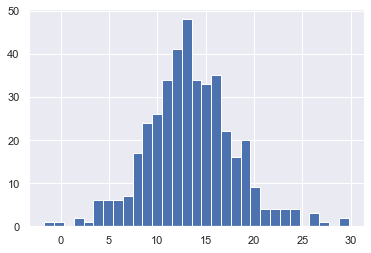

In [18]:
plt.hist(df['PER'], bins=31)

In [19]:
max_per = df[df['PER'] == df['PER'].max()]
print('Player with maximum PER for year {} is {} with PER of {}'.format(year, max_per.index[0], max_per['PER'][0]))


KeyError: 0

In [21]:
unique_pos = np.unique(df['Pos'])
print (unique_pos)

['C' 'PF' 'PG' 'SF' 'SG']


First let's look at the distribution of the PER accross all players for yaer 2014

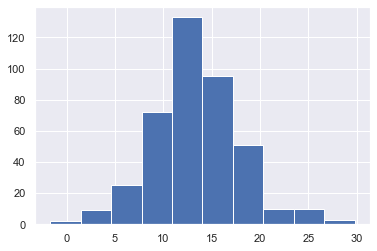

In [22]:
plt.hist(df['PER'])
plt.show()

Now we will split the data to positions to see if there is any diffrence

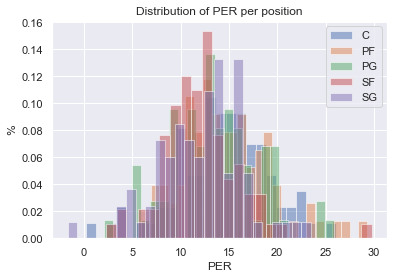

In [23]:
for p in unique_pos:
    plt.hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True)
plt.xlabel('PER')
plt.ylabel('%')
plt.title('Distribution of PER per position')
plt.legend()
plt.show()
#TODO: 1 figure of 5 PDFs (same colors). 2 Sub-plots

Assuming Normal distrebution - let's find the $\Theta=(\mu , \sigma)$ parameters for each position

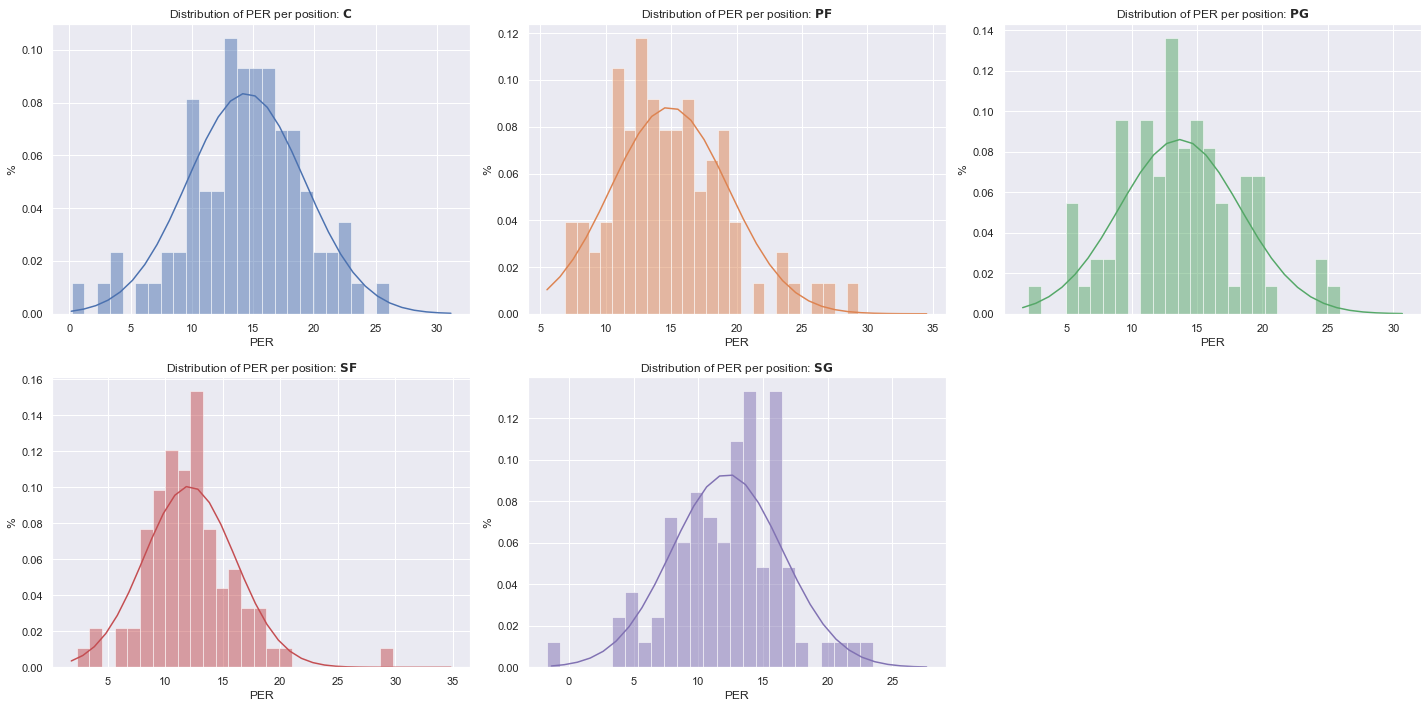

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i,p in enumerate(unique_pos):
    d = df[df['Pos']==p]['PER']
    x_axis = np.arange(np.min(d)*0.8, np.max(d)*1.2, 1)
    axes[i//3][i%3].plot(x_axis, scipy.stats.norm.pdf(x_axis,np.mean(d),np.std(d)), color=current_palette[i])
#     axes[i//3][i%3].hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True, color=current_palette[i])
    axes[i//3][i%3].hist(d, alpha=0.5, label=p, bins=25, density=True, color=current_palette[i])
    axes[i//3][i%3].set_xlabel('PER')
    axes[i//3][i%3].set_ylabel('%')
    axes[i//3][i%3].set_title(f'Distribution of PER per position: ' + r"$\bf{" + p + "}$")
# plt.legend()
axes[-1, -1].axis('off')
fig.tight_layout()
plt.show()


We can see from the plots above that the PER is now distributed the same accross all positions!!

OK... So that means that MVP should be the player that was performing best in his position.

We can start with taking the naive approach and see which is the player that is far from the mean value of the performances within the rest of the players in his position

In [20]:
def std_dist(per, mean_per, std_per):
    return (per-mean_per)/std_per

In [28]:
print (f"\033[4mYear: {year}\033[0m")
max_per_pos_dict = {}
for i,p in enumerate(unique_pos):
    pos_df = df[df['Pos']==p]
    max_per = pos_df[pos_df['PER'] == pos_df['PER'].max()]
    std_d = std_dist(max_per['PER'][0], np.mean(pos_df['PER']), np.std(pos_df['PER']))
    print (f'For position {p}:')
    print (f"Player with maximum PER within position is {max_per.index[0]} with PER = {max_per['PER'][0]}")
    print (f'Which is {std_d:.2f} far from mean value')
    max_per_pos_dict[p] = max_per

Year: 2014
For position C:
Player with maximum PER within position is DeMarcus Cousins with PER = 26.1
Which is 2.44 far from mean value
For position PF:
Player with maximum PER within position is LeBron James with PER = 29.3
Which is 3.19 far from mean value
For position PG:
Player with maximum PER within position is Chris Paul with PER = 25.9
Which is 2.64 far from mean value
For position SF:
Player with maximum PER within position is Kevin Durant with PER = 29.8
Which is 4.46 far from mean value
For position SG:
Player with maximum PER within position is James Harden with PER = 23.5
Which is 2.63 far from mean value


That is just.... Wow!

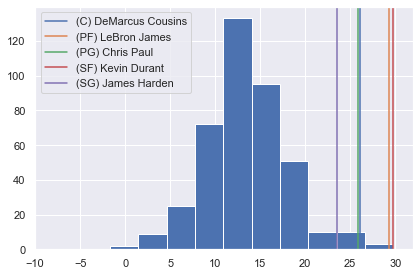

In [29]:
plt.hist(df['PER'])
for i,(k,v) in enumerate(max_per_pos_dict.items()):
    plt.axvline(v['PER'][0], color=current_palette[i], label=f"({k}) {v.index[0]}")
# fig = plt.figure(figsize=(18, 18))
plt.xlim(-10,32)
plt.tight_layout()
plt.legend()
plt.show()

OK. So if we want to extract the best player with regards to his position, we need to be able to find the best fit for the distribution of each position.

We will use few methods:

- Baysian Inference
- ABC 
- ...

The goal will be to compute the model parameters $\Theta=(\mu , \sigma)$ for each position.

We want to use the PER mean and STD as prior.

Let's first look at the PER over the last 15 years

In [30]:
years_range=(2005,2020)

In [31]:
# TODO: Fetching as module
columns_to_convert = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%',
                    'TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
mean_per = []
std_per = []
for y in range(*years_range,1):
    url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
    df=fetch_data(url)
    preprocess_df(columns_to_convert)
    mean_per.append(np.mean(df['PER']))
    std_per.append(np.std(df['PER']))

In [32]:
mean_per

[13.513054830287208,
 13.166666666666679,
 13.425765306122445,
 13.369210526315788,
 13.517847769028876,
 13.611111111111121,
 13.447814910025697,
 13.692171717171721,
 13.68337531486147,
 13.471219512195121,
 13.867303102625293,
 13.900726392251803,
 13.745762711864408,
 14.024396135265706,
 13.949761904761907]

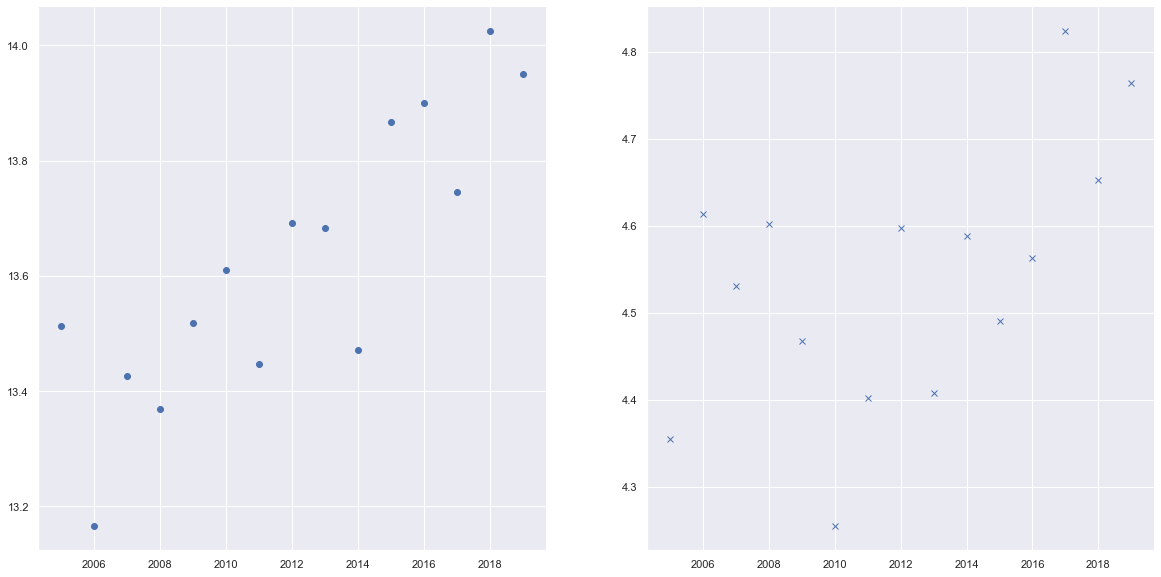

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(range(*years_range), mean_per, 'o')
axes[1].plot(range(*years_range), std_per, 'x')
sns.despine()


In [34]:
from scipy.optimize import curve_fit

In [35]:
def lin_func(x,a,b):
    return a*x+b

In [36]:
pars, cov = curve_fit(f=lin_func, xdata=range(*years_range,1), ydata=mean_per)

In [37]:
pars

array([ 4.61911430e-02, -7.93108338e+01])

In [38]:
cov

array([[ 6.02323459e-05, -1.21187480e-01],
       [-1.21187480e-01,  2.43830332e+02]])

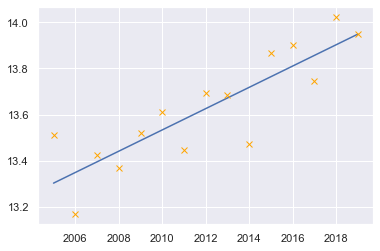

In [39]:
plt.plot(range(*years_range), lin_func(range(*years_range,1), pars[0], pars[1]))
plt.plot(range(*years_range), mean_per, 'x', color='orange')
plt.show()
#TODO: Add variance to the line. Maybe sample from the normal dist of a,b

In [40]:
def get_per(func, year, params):
    return func(year, *params)

In [41]:
get_per_mean_and_var(lin_func, 2016, pars)

NameError: name 'get_per_mean_and_var' is not defined

In [42]:
import statsmodels.api as sm

In [43]:
y = mean_per
X = sm.add_constant(range(*years_range)) # for intercept
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     35.42
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           4.81e-05
Time:                        23:14:15   Log-Likelihood:                 10.408
No. Observations:                  15   AIC:                            -16.82
Df Residuals:                      13   BIC:                            -15.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -79.3108     15.615     -5.079      0.0

/Users/amitklinger/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


# Baysian Inference for PER line

In [44]:
a_prior = scipy.stats.norm(5, 0.2)
b_prior = scipy.stats.norm(-9, 0.1)
σ_prior = scipy.stats.expon(0.1)

def log_prior(θ):
    a, b, σ = θ
    return a_prior.logpdf(a) + b_prior.logpdf(b) + σ_prior.logpdf(σ)

def log_likelihood(θ, x, y):
    a, b, σ = θ
    yhat = a * x + b
    return scipy.stats.norm(yhat, σ).logpdf(y).sum()

def log_posterior(θ, x, y):
    logpri = log_prior(θ)
    if np.isinf(logpri): return logpri
    return logpri + log_likelihood(θ, x, y)

In [45]:
ndim = 3
nwalkers = 50
nsteps  = 200
nburn = nsteps // 2
var_names = ['a', 'b', 'σ']

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] = a_prior.rvs(nwalkers)
guesses[:, 1] = b_prior.rvs(nwalkers)
guesses[:, 2] = σ_prior.rvs(nwalkers)

In [46]:
x = range(*years_range,1)
y = mean_per

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y])
sampler.run_mcmc(guesses, nsteps);

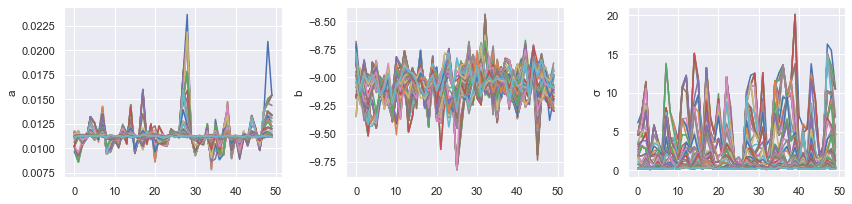

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, param in enumerate(['a', 'b', 'σ']):
    axes[i].plot(sampler.chain[:, nburn:, i])
    axes[i].set_ylabel(param)
fig.tight_layout()

In [48]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
θ_bayes = samples.mean(axis=0)
# print("Normal: a={:.3f}, b={:.3f}".format(*θ_norm))
print("Bayes:  a={:.3f}, b={:.3f}, σ={:.3f}".format(*θ_bayes))

Bayes:  a=0.011, b=-9.067, σ=1.710


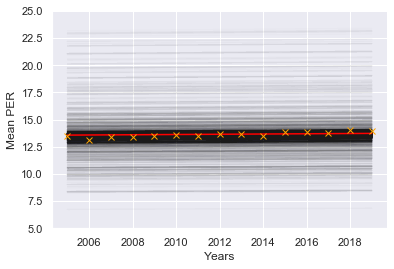

In [49]:
#plt.plot(lin_func(range(*years_range,1), pars[0], pars[1]))

for θi in samples:
    ai, bi, _ = θi
    yhat = ai * x + bi
    plt.plot(x, yhat, '-k', alpha=0.01)
    
a, b, σ = θ_bayes
yhat = a * x + b
plt.plot(x, yhat, color='red')
# comment out the next lines to get a predictive interval around the linear estimate
# plt.plot(x, yhat+σ, color=red)
# plt.plot(x, yhat-σ, color=red)

plt.plot(range(*years_range,1), mean_per, 'x', color='orange')
plt.ylim(5,25)

plt.xlabel('Years')
plt.ylabel('Mean PER')
sns.despine()

In [50]:
#TODO: Try to fit diffrent lines

In [51]:
from corner import corner

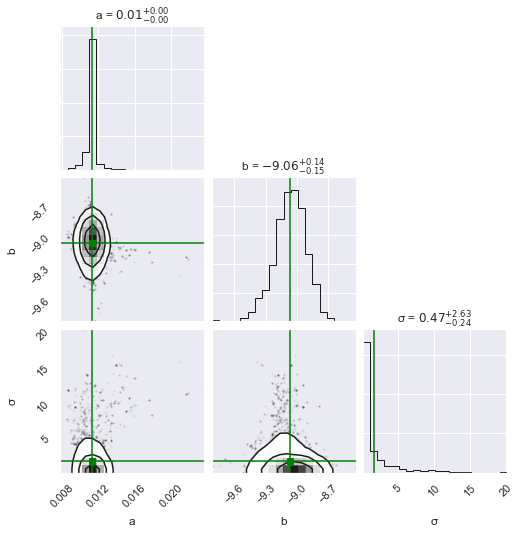

In [52]:
corner(
    samples, 
    smooth=True, 
    labels=var_names, 
    show_titles=True, 
    truths=θ_bayes, 
    truth_color="green"
);

In [ ]:
# Start of AMIT latest adds

# New MVP

In [55]:
#TODO: Make MVPs path according to username (not hardcoded)
mvps = '/Users/amitklinger/Documents/IDC/SciComPy/SciComPy/SciComPy_NBA/mvps.csv'
df_mvp = pd.read_csv(mvps,header=1)
df_mvp['Season'] = df_mvp['Season'].str[0:2] + df_mvp['Season'].str[-2:]
#         df[col] = pd.to_numeric(df[col])
df_mvp['Season'] = pd.to_numeric(df_mvp['Season'])
df_mvp['Player'] = df_mvp['Player'].map(lambda x: x.split('\\')[0])
# df['name'] = df['name'].map(lambda name: name.upper())


In [54]:
x = 'Giannis Antetokounmpo\antetgi01'
x.split('\\')
# xx = 'James Harden\hardeja01'
# xx.split('\\')
'Russell Westbrook\westbru01'.split('\\')

['Russell Westbrook', 'westbru01']

In [56]:
df_mvp

,Season,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2019,NBA,Giannis Antetokounmpo,(V),24,MIL,72,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,0.292
1,2018,NBA,James Harden,(V),28,HOU,72,35.4,30.4,5.4,8.8,1.8,0.7,0.449,0.367,0.858,15.4,0.289
2,2017,NBA,Russell Westbrook,(V),28,OKC,81,34.6,31.6,10.7,10.4,1.6,0.4,0.425,0.343,0.845,13.1,0.224
3,2016,NBA,Stephen Curry,(V),27,GSW,79,34.2,30.1,5.4,6.7,2.1,0.2,0.504,0.454,0.908,17.9,0.318
4,2015,NBA,Stephen Curry,(V),26,GSW,80,32.7,23.8,4.3,7.7,2.0,0.2,0.487,0.443,0.914,15.7,0.288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1960,NBA,Wilt Chamberlain,(V),23,PHW,72,46.4,37.6,27.0,2.3,NaN,NaN,0.461,NaN,0.582,17.0,0.245
60,1959,NBA,Bob Pettit,(V),26,STL,72,39.9,29.2,16.4,3.1,NaN,NaN,0.438,NaN,0.759,14.8,0.246
61,1958,NBA,Bill Russell,(V),23,BOS,69,38.3,16.6,22.7,2.9,NaN,NaN,0.442,NaN,0.519,11.3,0.206
62,1957,NBA,Bob Cousy,(V),28,BOS,64,36.9,20.6,4.8,7.5,NaN,NaN,0.378,NaN,0.821,8.8,0.178


In [22]:
# Convert MVP df to dict and copy to version2
mvps_dict = dict(zip(df_mvp['Season'], df_mvp['Player']))
mvps_dict

{2019: 'Giannis Antetokounmpo\\antetgi01',
 2018: 'James Harden\\hardeja01',
 2017: 'Russell Westbrook\\westbru01',
 2016: 'Stephen Curry\\curryst01',
 2015: 'Stephen Curry\\curryst01',
 2014: 'Kevin Durant\\duranke01',
 2013: 'LeBron James\\jamesle01',
 2012: 'LeBron James\\jamesle01',
 2011: 'Derrick Rose\\rosede01',
 2010: 'LeBron James\\jamesle01',
 2009: 'LeBron James\\jamesle01',
 2008: 'Kobe Bryant\\bryanko01',
 2007: 'Dirk Nowitzki\\nowitdi01',
 2006: 'Steve Nash\\nashst01',
 2005: 'Steve Nash\\nashst01',
 2004: 'Kevin Garnett\\garneke01',
 2003: 'Tim Duncan\\duncati01',
 2002: 'Tim Duncan\\duncati01',
 2001: 'Allen Iverson\\iversal01',
 1900: "Shaquille O'Neal\\onealsh01",
 1999: 'Karl Malone\\malonka01',
 1998: 'Michael Jordan\\jordami01',
 1997: 'Karl Malone\\malonka01',
 1996: 'Michael Jordan\\jordami01',
 1995: 'David Robinson\\robinda01',
 1994: 'Hakeem Olajuwon\\olajuha01',
 1993: 'Charles Barkley\\barklch01',
 1992: 'Michael Jordan\\jordami01',
 1991: 'Michael Jordan\\j

,Season,Lg,Player,Voting,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Tweat
0,2019,NBA,Giannis Antetokounmpo,(V),24,MIL,72,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,0.292,antetgi01
1,2018,NBA,James Harden,(V),28,HOU,72,35.4,30.4,5.4,8.8,1.8,0.7,0.449,0.367,0.858,15.4,0.289,hardeja01
2,2017,NBA,Russell Westbrook,(V),28,OKC,81,34.6,31.6,10.7,10.4,1.6,0.4,0.425,0.343,0.845,13.1,0.224,westbru01
3,2016,NBA,Stephen Curry,(V),27,GSW,79,34.2,30.1,5.4,6.7,2.1,0.2,0.504,0.454,0.908,17.9,0.318,curryst01
4,2015,NBA,Stephen Curry,(V),26,GSW,80,32.7,23.8,4.3,7.7,2.0,0.2,0.487,0.443,0.914,15.7,0.288,curryst01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1960,NBA,Wilt Chamberlain,(V),23,PHW,72,46.4,37.6,27.0,2.3,NaN,NaN,0.461,NaN,0.582,17.0,0.245,chambwi01
60,1959,NBA,Bob Pettit,(V),26,STL,72,39.9,29.2,16.4,3.1,NaN,NaN,0.438,NaN,0.759,14.8,0.246,pettibo01
61,1958,NBA,Bill Russell,(V),23,BOS,69,38.3,16.6,22.7,2.9,NaN,NaN,0.442,NaN,0.519,11.3,0.206,russebi01
62,1957,NBA,Bob Cousy,(V),28,BOS,64,36.9,20.6,4.8,7.5,NaN,NaN,0.378,NaN,0.821,8.8,0.178,cousybo01


In [24]:
years_range = (2013,2020)

In [25]:
def create_database(years):
    columns_to_convert = ['G','PER'] # ['Age','G','MP','PER']
    wanted_columns = ['Player','Pos','PER']
    db = pd.DataFrame()

    for y in range(*years,1):
        url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
        df_tmp = fetch_data(url)
        df_tmp = preprocess_df(df_tmp, columns_to_convert)
        df_tmp = df_tmp[wanted_columns]
        df_tmp['Year'] = y
        df_tmp['MVP'] = False
        df_tmp.loc[df_tmp['Player'] == mvps_dict[y], 'MVP'] = True # Add MVP boolean column to db
        db = db.append(df_tmp, ignore_index=True)
        
    return db

In [26]:
dbb = create_database(years_range)

In [30]:
ddd = dbb.loc[dbb['MVP'] == True]
ddd

,Player,Pos,PER,Year,MVP


In [101]:
from termcolor import colored
def get_max_per(df):
    max_per = df[df['PER'] == df['PER'].max()]
    max_per_val, max_per_player = max_per.iloc[0]['PER'], max_per.iloc[0]['Player']
    return max_per_val, max_per_player

def compare_mvp_vs_max_per(db):
    years = np.unique(db['Year'])
    for year in years:
        df = db[db['Year'] == year]
#         mvp_winner = mvps[mvps['Season'] == year].iloc[0]['Player']
        mvp_winner = df.loc[df['MVP'] == True, 'Player'].values[0]
#         max_per = df[df['PER'] == df['PER'].max()]
#         max_per_val, max_per_player = max_per.iloc[0]['PER'], max_per.iloc[0]['Player']
        max_per_val, max_per_player = get_max_per(df)
        ccolor = 'grey' if max_per_player == mvp_winner else 'red'
        print (f"\033[4mYear: {year}\033[0m")
        print(colored('Player with maximum PER is {} with PER of {}.\nMVP Winner = {}'.format(max_per_player, max_per_val, mvp_winner),ccolor))
        

In [93]:
df = dbb[dbb['Year'] == 2013]
bb = df[df['MVP'] == True]['Player']
aa = df.loc[df['MVP'] == True, 'Player'].values[0]
# x.loc[x['A'] == 2, 'B']

# cc = df.loc[df['MVP'] == True].at['Player']
aa

182    LeBron James
Name: Player, dtype: object

In [98]:
df.loc[df['MVP'] == True, 'Player'].values[0]

'LeBron James'

In [102]:
compare_mvp_vs_max_per(dbb)

Year: 2013
Player with maximum PER is LeBron James with PER of 31.6.
MVP Winner = LeBron James
Year: 2014
Player with maximum PER is Kevin Durant with PER of 29.8.
MVP Winner = Kevin Durant
Year: 2015
Player with maximum PER is Anthony Davis with PER of 30.8.
MVP Winner = Stephen Curry
Year: 2016
Player with maximum PER is Stephen Curry with PER of 31.5.
MVP Winner = Stephen Curry
Year: 2017
Player with maximum PER is Russell Westbrook with PER of 30.6.
MVP Winner = Russell Westbrook
Year: 2018
Player with maximum PER is James Harden with PER of 29.8.
MVP Winner = James Harden
Year: 2019
Player with maximum PER is Giannis Antetokounmpo with PER of 30.9.
MVP Winner = Giannis Antetokounmpo


In [ ]:
print (f"\033[4mYear: {year}\033[0m")
max_per_pos_dict = {}
for i,p in enumerate(unique_pos):
    pos_df = df[df['Pos']==p]
    max_per = pos_df[pos_df['PER'] == pos_df['PER'].max()]
    std_d = std_dist(max_per['PER'][0], np.mean(pos_df['PER']), np.std(pos_df['PER']))
    print (f'For position {p}:')
    print (f"Player with maximum PER within position is {max_per.index[0]} with PER = {max_per['PER'][0]}")
    print (f'Which is {std_d:.2f} far from mean value')
    max_per_pos_dict[p] = max_per

In [60]:

def add_std_dist_2_db(db, μ, σ, year, pos):
    df1 = db.loc[(db['Year'] == year) & (db['Pos'] == pos)].copy()
#     μ = df1['PER'].mean()
#     σ = df1['PER'].std()
    df1.loc[:, 'std_dist'] = round(std_dist(df1['PER'], μ, σ),2)
    db.loc[df1.index,'std_dist'] = df1['std_dist']
    return

In [136]:
# df.loc[(df.a != 1) & (df.b < 5)]

df1 = dbb.loc[(dbb['Year'] == 2017) & (dbb['Pos'] == 'C')].copy()
μ = df1['PER'].mean()
σ = df1['PER'].std()
# dd = std_dist(df1['PER'], μ, σ)
# df1['std_dist'] = round(std_dist(df1['PER'], μ, σ),2)
# df1.index
df1.loc[:, 'std_dist'] = round(std_dist(df1['PER'], μ, σ),2)
# dbb.index[dbb['Year'] == 2017].tolist() # 1641-2053
# # df1
# dbb

In [140]:
df1.index

Int64Index([1643, 1645, 1646, 1659, 1671, 1682, 1684, 1687, 1704, 1709, 1710,
            1721, 1730, 1731, 1733, 1744, 1751, 1759, 1767, 1770, 1771, 1776,
            1779, 1789, 1790, 1794, 1803, 1805, 1807, 1809, 1816, 1818, 1819,
            1830, 1840, 1845, 1847, 1848, 1853, 1863, 1872, 1873, 1874, 1881,
            1882, 1883, 1893, 1899, 1907, 1913, 1918, 1926, 1927, 1928, 1930,
            1932, 1933, 1935, 1937, 1938, 1947, 1948, 1949, 1950, 1954, 1960,
            1992, 1994, 2005, 2008, 2011, 2014, 2019, 2029, 2033, 2036, 2042,
            2050, 2051, 2053],
           dtype='int64')

In [141]:
df1

,Player,Pos,PER,Year,MVP,std_dist
1643,Steven Adams,C,16.5,2017,False,-0.14
1645,Alexis Ajinça,C,12.9,2017,False,-0.94
1646,Cole Aldrich,C,12.7,2017,False,-0.99
1659,Ömer Aşık,C,9.8,2017,False,-1.64
1671,Aron Baynes,C,13.1,2017,False,-0.90
...,...,...,...,...,...,...
2036,Alan Williams,C,19.5,2017,False,0.54
2042,Jeff Withey,C,18.8,2017,False,0.38
2050,Cody Zeller,C,16.7,2017,False,-0.09
2051,Tyler Zeller,C,13.0,2017,False,-0.92


In [142]:
dbb.loc[df1.index,'std_dist'] = df1['std_dist']

In [144]:
dbb.loc[df1.index]

,Player,Pos,PER,Year,MVP,std_dist
1643,Steven Adams,C,16.5,2017,False,-0.14
1645,Alexis Ajinça,C,12.9,2017,False,-0.94
1646,Cole Aldrich,C,12.7,2017,False,-0.99
1659,Ömer Aşık,C,9.8,2017,False,-1.64
1671,Aron Baynes,C,13.1,2017,False,-0.90
...,...,...,...,...,...,...
2036,Alan Williams,C,19.5,2017,False,0.54
2042,Jeff Withey,C,18.8,2017,False,0.38
2050,Cody Zeller,C,16.7,2017,False,-0.09
2051,Tyler Zeller,C,13.0,2017,False,-0.92


In [61]:
add_std_dist_col(dbb, 15, 1, 2017, 'C')

(413, 5)
(80, 5)
1643    1.5
1645   -2.1
1646   -2.3
1659   -5.2
1671   -1.9
       ... 
2036    4.5
2042    3.8
2050    1.7
2051   -2.0
2053    2.0
Name: std_dist, Length: 80, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [337]:

def get_new_per(db, year):
    df = db[db['Year'] == year]
    unique_pos = np.unique(df['Pos'])
    print (f"\033[4mYear: {year}\033[0m")
    max_per_pos_dict = {}
    max_stds = 0
    max_pos = None
    for p in unique_pos:
        pos_df = df[df['Pos']==p]
        max_per_val, max_per_player = get_max_per(pos_df)
        std_d = std_dist(max_per_val, np.mean(pos_df['PER']), np.std(pos_df['PER']))
        if std_d > max_stds:
            max_stds = std_d
            max_pos = p
#         print (f'For position {p}:')
#         print (f"Player with maximum PER within position is {max_per_player} with PER = {max_per_val}")
#         print (f'Which is {std_d:.2f} far from mean value')
        max_per_pos_dict[p] = {'Player' : max_per_player, 'PER' : max_per_val, 'stds_dist' : np.round(std_d,2)}
    mvp_according_new_per = max_per_pos_dict[max_pos]
    print(colored('MVP According to new-PER calculation should be {} with PER of {}, stds_dist = {}'.format(mvp_according_new_per['Player'], mvp_according_new_per['PER'], mvp_according_new_per['stds_dist']),'cyan'))
    return max_per_pos_dict, max_pos


In [354]:
new_per_mvps = {}
for year in np.unique(dbb['Year']):
    pos_dict, max_pos = get_new_per(dbb, year)
#     new_per_mvps.append({'Year' : year, 'New_MVP' : pos_dict[max_pos]['Player']})
#     new_per_mvps.append({year : pos_dict[max_pos]['Player']})
    new_per_mvps[year] = pos_dict[max_pos]['Player']
print("*"*55)
print(new_per_mvps)

Year: 2013
MVP According to new-PER calculation should be Kevin Durant with PER of 28.3, stds_dist = 4.5
Year: 2014
MVP According to new-PER calculation should be Kevin Durant with PER of 29.8, stds_dist = 4.46
Year: 2015
MVP According to new-PER calculation should be Anthony Davis with PER of 30.8, stds_dist = 3.85
Year: 2016
MVP According to new-PER calculation should be Stephen Curry with PER of 31.5, stds_dist = 3.75
Year: 2017
MVP According to new-PER calculation should be DeMar DeRozan with PER of 24.0, stds_dist = 3.5
Year: 2018
MVP According to new-PER calculation should be James Harden with PER of 29.8, stds_dist = 4.2
Year: 2019
MVP According to new-PER calculation should be Giannis Antetokounmpo with PER of 30.9, stds_dist = 4.0
{2013: 'Kevin Durant', 2014: 'Kevin Durant', 2015: 'Anthony Davis', 2016: 'Stephen Curry', 2017: 'DeMar DeRozan', 2018: 'James Harden', 2019: 'Giannis Antetokounmpo'}


/Users/amitklinger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [358]:
def compare_mvp_2_newmvp(mvps, new_per_mvps):
    for year in np.unique(dbb['Year']):
        mvp_winner = mvps[mvps['Season'] == year].iloc[0]['Player']
        new_mvp_winner = new_per_mvps[year]
        ccolor = 'grey' if mvp_winner == new_mvp_winner else 'red'
        print(colored("mvp_winner = {}".format(mvp_winner), ccolor))
        print(colored("new_mvp_winner = {}".format(new_mvp_winner), ccolor))
        print("*"*55)


compare_mvp_2_newmvp(df_mvp, new_per_mvps)


mvp_winner = LeBron James
new_mvp_winner = Kevin Durant
*******************************************************
mvp_winner = Kevin Durant
new_mvp_winner = Kevin Durant
*******************************************************
mvp_winner = Stephen Curry
new_mvp_winner = Anthony Davis
*******************************************************
mvp_winner = Stephen Curry
new_mvp_winner = Stephen Curry
*******************************************************
mvp_winner = Russell Westbrook
new_mvp_winner = DeMar DeRozan
*******************************************************
mvp_winner = James Harden
new_mvp_winner = James Harden
*******************************************************
mvp_winner = Giannis Antetokounmpo
new_mvp_winner = Giannis Antetokounmpo
*******************************************************
